In [1]:
PYTHON_PATHS = [".."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)

In [2]:
import numpy as np
import os
from tqdm.notebook import tqdm as tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import kapture
import cv2
import tempfile

In [3]:
from unsupkeypoints.data import DescriptorDataModule
from unsupkeypoints.models import PointNetwork, BinarizationPointNetwork, SimpleModel
from unsupkeypoints.criterions import RegressionLoss, RGBandModelReprojectionLoss
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.utilities.parsing import AttributeDict
import torch
import pytorch_lightning as pl
import tqdm
from collections import Counter
from unsupkeypoints.utils.universal_factory import UniversalFactory
factory = UniversalFactory([PointNetwork, RegressionLoss, RGBandModelReprojectionLoss,
                            BinarizationPointNetwork, SimpleModel])

# Load dataset

In [4]:
from clearml import Dataset
dataset_path = Dataset.get(dataset_id="40300e50677746148777e4a3c3a21ba9").get_local_copy()

In [5]:
TRAIN_PATH = os.path.join(dataset_path, "output_kapture/7scenes/fire/mapping")
TEST_PATH = os.path.join(dataset_path, "output_kapture/7scenes/fire/query")

In [6]:
data_module = DescriptorDataModule(TRAIN_PATH, TEST_PATH)

[DescriptorDataModule] - train dataset size 389950
[DescriptorDataModule] - test dataset size 346052


In [7]:
data_module._batch_size = 1024

# Load model

In [8]:
model_path = "/home/mikhail/.clearml/cache/lightning_logs/fire/version_6/checkpoints/epoch=39-step=30479.ckpt"
# model_path = "/home/mikhail/.clearml/cache/lightning_logs/fire/version_8/checkpoints/epoch=39-step=30479.ckpt"
# model_path = "/home/mikhail/.clearml/cache/lightning_logs/fire/version_7/checkpoints/epoch=49-step=38099.ckpt"

In [9]:
params = AttributeDict(
    name="BinarizationPointNetwork",
    optimizer=AttributeDict(
        lr=1e-3
    ),
    classifier=AttributeDict(
        name="SimpleModel",
        input_dimension=512,
        hidden_dimensions=(256,),
        output_dimension=64
    ),
    regressor=AttributeDict(
        name="SimpleModel",
        input_dimension=64,
        hidden_dimensions=(64,),
        output_dimension=3
    ),
    criterion={
        "name": "RGBandModelReprojectionLoss",
        "minimal_depth": 0.1,
        "maximal_distance": 0.05,
        "maximal_reprojection_loss": 1000,
        "robust_maximal_reprojection_loss": 100,
        "distance_coef": 1000
    },
    probabilistic=True,
    sigmoid_after_classifier=True,
    max_probability_error=0.45,
    metric_logging_frequency=2,
)
model = factory.make_from_parameters(params)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

# Calculate result

In [10]:
from unsupkeypoints.utils.result_saver import ResultSaver
from unsupkeypoints.utils.math import calculate_errors

In [11]:
result_saver = ResultSaver()
for batch in tqdm.tqdm(data_module.test_dataloader()):
    probabilites = torch.sigmoid(model._classifier(batch["descriptor"]))
    predicted_points = model(batch["descriptor"])[0]
    result_saver.save({
        "predicted_point3d": predicted_points,
        "probabilites": probabilites,
        "keypoint": batch["keypoint"],
        "image_index": batch["image_index"],
        "position": batch["position"],
        "point3d": batch["point3d"],
    })

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 338/338 [00:08<00:00, 42.17it/s]


In [12]:
point_errors = np.linalg.norm(result_saver["predicted_point3d"] - result_saver["point3d"], axis=1)
probability_errors = np.mean(np.abs(0.5 - result_saver["probabilites"]), axis=1)

In [13]:
np.mean(point_errors)

0.17898664

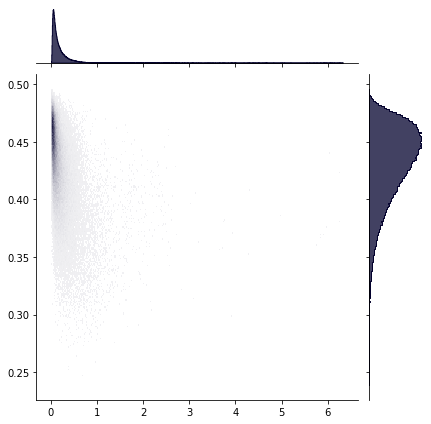

In [14]:
g = sns.JointGrid(x=point_errors, y=probability_errors)
g.plot_joint(
    sns.histplot,
    cmap="light:#03012d",
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

# PnP estimation

In [15]:
class PositionEstimator(object):
    def __init__(self, flags=cv2.SOLVEPNP_EPNP):
        self._camera_matrix = np.array([[525., 0, 320],
                                           [0, 525., 240],
                                           [0, 0, 1]])
        self._dist_coef = np.zeros(5)
        self._point_count_threshold = 6
        self._flags = flags

    def calculate_position_errors(self, points3d, keypoints, image_indexes, ground_truth_positions):
        image_index_list = self.get_image_index_list(image_indexes)
        estimated_positions = self.estimate_positions(points3d, 
                                                      keypoints, 
                                                      image_indexes, 
                                                      image_index_list)
        ground_truth_positions = self.filter_truth_positions(ground_truth_positions, 
                                                             image_indexes, 
                                                             image_index_list)
        return calculate_errors(estimated_positions, ground_truth_positions, True)

    def filter_truth_positions(self, ground_truth_positions, image_indexes, image_index_list):
        result = []
        for index in image_index_list:
            image_mask = image_indexes == index
            result.append(ground_truth_positions[image_mask][0])
        return np.array(result)

    def estimate_positions(self, points3d, keypoints, image_indexes, image_index_list):
        result = []
        for index in tqdm.tqdm(image_index_list):
            image_mask = image_indexes == index
            image_points3d = points3d[image_mask]
            image_keypoints = keypoints[image_mask]
            recovered_position = self.estimate_position(image_points3d, image_keypoints)
            result.append(recovered_position)
        return np.array(result)

    def get_image_index_list(self, image_indexes):
        image_index_list = sorted(list(set(image_indexes)))
        return image_index_list

    def estimate_position(self, image_points3d, image_keypoints):
        rvec, tvec = self.solve_pnp(image_points3d, image_keypoints)
        return self.position_from_pnp_result(rvec, tvec)

    def solve_pnp(self, image_points3d, image_keypoints):
        found, rvec, tvec = cv2.solvePnP(image_points3d,
                                         image_keypoints,
                                         self._camera_matrix,
                                         self._dist_coef,
                                         flags=self._flags)
        return rvec, tvec

    def position_from_pnp_result(self, rvec, tvec):
        rotation = cv2.Rodrigues(rvec)[0]
        translation = -np.matrix(rotation).T * np.matrix(tvec)
        translation = np.array(translation)[:, 0]
        recovered_camera_position = np.zeros((4, 4))
        recovered_camera_position[:3, :3] = rotation.T
        recovered_camera_position[:3, 3] = translation
        recovered_camera_position[3, 3] = 1
        return recovered_camera_position

In [16]:
def calculate_result_saver_errors(position_estimator, result_saver):
    return position_estimator.calculate_position_errors(
        result_saver["predicted_point3d"],
        result_saver["keypoint"],
        result_saver["image_index"],
        result_saver["position"])

In [17]:
position_estimator = PositionEstimator()
result = calculate_result_saver_errors(position_estimator, result_saver)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 644.57it/s]


Mean position error: 0.4376723243734025
Median position error: 0.2930460722545971
Mean rotation error: 15.804132865170883
Median rotation error: 7.498139826194903


In [18]:
position_estimator = PositionEstimator(cv2.SOLVEPNP_ITERATIVE)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:05<00:00, 368.48it/s]


Mean position error: 5188420418.959368
Median position error: 2.348427303766469
Mean rotation error: 103.03009512234577
Median rotation error: 169.10760882237417


In [19]:
position_estimator = PositionEstimator(cv2.SOLVEPNP_SQPNP)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 638.31it/s]


Mean position error: 0.42876536375925894
Median position error: 0.2902537561861733
Mean rotation error: 19.368598298876744
Median rotation error: 8.48247837633046


## Ransac

In [20]:
class PositionEstimatorRansac(PositionEstimator):
    def solve_pnp(self, image_points3d, image_keypoints):
        found, rvec, tvec, inliers = cv2.solvePnPRansac(image_points3d,
                                         image_keypoints,
                                         self._camera_matrix,
                                         self._dist_coef,
                                         flags=self._flags)
        return rvec, tvec

In [21]:
position_estimator = PositionEstimatorRansac()
result = calculate_result_saver_errors(position_estimator, result_saver)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 133.26it/s]


Mean position error: 0.31554491436749765
Median position error: 0.13610376383005762
Mean rotation error: 16.041920221727892
Median rotation error: 4.863610945273647


In [22]:
position_estimator = PositionEstimatorRansac(cv2.SOLVEPNP_ITERATIVE)
result = calculate_result_saver_errors(position_estimator, result_saver)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:15<00:00, 129.61it/s]


Mean position error: 1710931.5203962685
Median position error: 0.16868038222221238
Mean rotation error: 47.62461005766968
Median rotation error: 6.117465265205119


In [23]:
position_estimator = PositionEstimatorRansac(cv2.SOLVEPNP_SQPNP)
result = calculate_result_saver_errors(position_estimator, result_saver)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 134.88it/s]


Mean position error: 0.2963110134414695
Median position error: 0.13481844408749322
Mean rotation error: 15.486976995654183
Median rotation error: 4.822773290396752


## Probabilites

In [24]:
def calculate_score(probabilities):
    return np.mean(np.abs(0.5 - probabilities), axis=1)

In [25]:
class ScoredPositionEstimator(PositionEstimator):
    def __init__(self, flags=cv2.SOLVEPNP_EPNP, maximum_point_count=100, minimal_score=0.45):
        super().__init__(flags)
        self._maximum_point_count = maximum_point_count
        self._minimal_score = minimal_score

    def calculate_position_errors(self, points3d, keypoints, image_indexes, ground_truth_positions, scores):
        image_index_list = self.get_image_index_list(image_indexes)
        estimated_positions = self.estimate_positions(points3d, 
                                                      keypoints, 
                                                      image_indexes, 
                                                      image_index_list,
                                                      scores)
        ground_truth_positions = self.filter_truth_positions(ground_truth_positions, 
                                                             image_indexes, 
                                                             image_index_list)
        return calculate_errors(estimated_positions, ground_truth_positions, True)
    
    def estimate_positions(self, points3d, keypoints, image_indexes, image_index_list, scores):
        result = []
        for index in tqdm.tqdm(image_index_list):
            image_mask = image_indexes == index
            score_mask = self.calculate_score_mask(scores[image_mask])
            image_points3d = points3d[image_mask][score_mask]
            image_keypoints = keypoints[image_mask][score_mask]
            recovered_position = self.estimate_position(image_points3d, image_keypoints)
            result.append(recovered_position)
        return np.array(result)
    
    def calculate_score_mask(self, scores):
        sorted_scores = np.sort(scores)
        arg_sorted_scores = np.argsort(scores)
        good_score_count = self.calculate_good_score_count(sorted_scores)
        good_score_indexes = arg_sorted_scores[-good_score_count:]
        mask = np.zeros_like(scores, dtype=np.bool)
        mask[good_score_indexes] = True
        return mask

    def calculate_good_score_count(self, sorted_scores):
        good_score_count = len(sorted_scores) - np.searchsorted(sorted_scores, self._minimal_score)
        good_score_count = min(self._maximum_point_count, good_score_count)
        good_score_count = max(self._point_count_threshold, good_score_count)
        return good_score_count

In [26]:
position_estimator = ScoredPositionEstimator(maximum_point_count=100, minimal_score=0.45)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 594.12it

Mean position error: 0.25439237360515976
Median position error: 0.1100726980668662
Mean rotation error: 12.845261722209687
Median rotation error: 3.7187431094748615


In [27]:
position_estimator = ScoredPositionEstimator(flags=cv2.SOLVEPNP_ITERATIVE)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:04<00:00, 448.41it

Mean position error: 30170923.974164005
Median position error: 1.1171397857237526
Mean rotation error: 82.41175371473715
Median rotation error: 32.61323523178399


In [28]:
position_estimator = ScoredPositionEstimator(flags=cv2.SOLVEPNP_SQPNP)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:03<00:00, 585.66it

Mean position error: 0.23523332986780246
Median position error: 0.0996552296152372
Mean rotation error: 12.686266161626865
Median rotation error: 3.3325925488649357


# Ransac scored

In [29]:
class ScoredPositionEstimatorRansac(ScoredPositionEstimator):
    def solve_pnp(self, image_points3d, image_keypoints):
        found, rvec, tvec, inliers = cv2.solvePnPRansac(image_points3d,
                                         image_keypoints,
                                         self._camera_matrix,
                                         self._dist_coef,
                                         flags=self._flags)
        return rvec, tvec

In [30]:
position_estimator = ScoredPositionEstimatorRansac(maximum_point_count=100, minimal_score=0.45)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 142.79it

Mean position error: 0.3023833603173864
Median position error: 0.11168111734256637
Mean rotation error: 15.78413641259045
Median rotation error: 3.9780823275323955


In [31]:
position_estimator = ScoredPositionEstimatorRansac(flags=cv2.SOLVEPNP_ITERATIVE)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:14<00:00, 137.04it

Mean position error: 3462196630.396
Median position error: 0.18973526985328484
Mean rotation error: 60.462796642482395
Median rotation error: 7.63867035354915


In [32]:
position_estimator = ScoredPositionEstimatorRansac(flags=cv2.SOLVEPNP_SQPNP)
position_errors, rotation_errors = position_estimator.calculate_position_errors(
    result_saver["predicted_point3d"],
    result_saver["keypoint"],
    result_saver["image_index"],
    result_saver["position"],
    calculate_score(result_saver["probabilites"]))

  0%|                                                                                                                                                                                                                                                    | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_231762/2588326741.py:35: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(scores, dtype=np.bool)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:13<00:00, 144.30it

Mean position error: 0.3002626861922862
Median position error: 0.10923210295980715
Mean rotation error: 15.825203747955564
Median rotation error: 3.9607034922768847
